In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=37a45467ee8cde860682feec196339dba91b80e8e3c6ce27e408e460ef999614
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from datetime import datetime as dt, timedelta as td
from pykalman import KalmanFilter
from sklearn.metrics import mean_absolute_error
sns.set()

In [4]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/drive/MyDrive/Kalman Filter/NVDA Historical Data.csv')
df1=df.reset_index()['Price']

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
train_data_matrix = np.array(train_data).reshape(-1, 1)
test_data_matrix = np.array(test_data).reshape(-1, 1)
val_data_matrix = np.array(val_data).reshape(-1, 1)

In [7]:
# Xây dựng mô hình Kalman
# kf = KalmanFilter(k_endog=1, k_states=1)
kf = KalmanFilter(n_dim_obs=1, n_dim_state=1, initial_state_mean=train_data_matrix[0],
                  initial_state_covariance=np.eye(1),
                  transition_matrices=np.eye(1),
                  observation_matrices=np.eye(1),
                  observation_covariance=np.eye(1),
                  transition_covariance=np.eye(1))

# kf = KalmanFilter(initial_state_mean=train_data[0],
#                   initial_state_covariance=1,
#                   observation_covariance=1,
#                   transition_covariance=0.01)

In [8]:
# Huấn luyện mô hình Kalman trên tập dữ liệu huấn luyện
kf.em(train_data_matrix, n_iter=10)

In [9]:
# Dự đoán trên tập kiểm tra và tập validation
test_pred, test_cov = kf.filter(test_data_matrix)
val_pred, val_cov = kf.filter(val_data_matrix)

In [10]:
# Đánh giá độ chính xác thuật toán bằng RMSE, MAE
valid_rmse = np.sqrt(np.mean((val_pred - val_data_matrix)**2))
test_rmse = np.sqrt(np.mean((test_pred - test_data_matrix)**2))

valid_mae = mean_absolute_error(val_data_matrix, val_pred)
test_mae = mean_absolute_error(test_data_matrix, test_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Validation RMSE: 7.359553100893595
Validation MAE: 1.8550579103570966
Testing RMSE: 9.344344286330498
Testing MAE: 1.806693692513575


In [11]:
# Dự đoán giá cổ phiếu của 30 ngày tiếp theo
last_observation = val_data_matrix[-1]
predicted_means, predicted_covs = kf.filter(np.repeat(last_observation, 30, axis=0))

# Trích xuất giá dự đoán từ các trạng thái dự báo
predicted_prices = predicted_means.flatten()

In [12]:
last_observation

array([426.53])

In [13]:
predicted_prices

array([ 55.89096277, 344.87816895, 410.95781256, 423.57682124,
       425.9700597 , 426.42383275, 426.50987021, 426.5261833 ,
       426.52927634, 426.52986279, 426.52997398, 426.52999507,
       426.52999906, 426.52999982, 426.52999997, 426.52999999,
       426.53      , 426.53      , 426.53      , 426.53      ,
       426.53      , 426.53      , 426.53      , 426.53      ,
       426.53      , 426.53      , 426.53      , 426.53      ,
       426.53      , 426.53      ])

Validation RMSE: 7.359553100893595
Validation MAE: 1.8550579103570966
Testing RMSE: 9.344344286330498
Testing MAE: 1.806693692513575


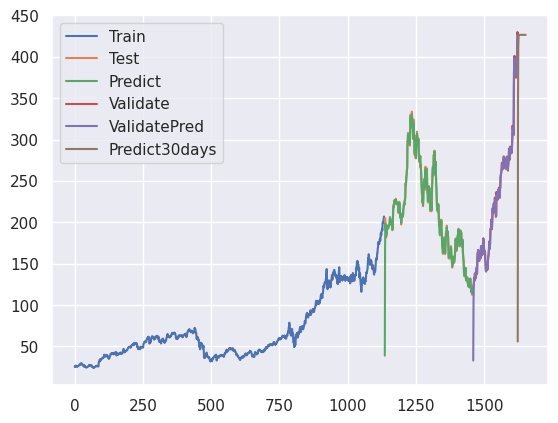

In [14]:
# 14.Vẽ hình
print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data)

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data)

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_pred)

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,val_data)

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,val_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,predicted_prices)

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

Giá trị của predicted_prices có xu hướng chạy về giá trị cuối cùng trong tập validation (last_observation) là do tính chất của mô hình Kalman Filter.

Kalman Filter là một mô hình dự đoán trạng thái, nghĩa là nó dự đoán giá trị của một biến không quan sát được (trạng thái) dựa trên các biến quan sát được (giá cổ phiếu) và các thông tin thêm về quá trình chuyển động của biến không quan sát được đó. Trong quá trình dự đoán, Kalman Filter sử dụng các thông tin về trạng thái trước đó để cập nhật và dự đoán trạng thái hiện tại.

Khi dự đoán giá cổ phiếu của 30 ngày tiếp theo, mô hình Kalman Filter sẽ sử dụng giá trị cuối cùng trong tập validation (last_observation) làm giá trị ban đầu và tính toán kì vọng của giá cổ phiếutrong 30 ngày tiếp theo dựa trên mô hình Kalman Filter đã được huấn luyện trên tập train và các thông tin về quá trình chuyển động của giá cổ phiếu.

Do đó, nếu giá trị cuối cùng trong tập validation là giá trị gần với trung bình của giá cổ phiếu trong tập train, thì các giá trị dự đoán của Kalman Filter trong 30 ngày tiếp theo sẽ có xu hướng chạy về giá trị cuối cùng trong tập validation. Điều này là do mô hình Kalman Filter cần thời gian để thích nghi với các thay đổi của quá trình chuyển động của giá cổ phiếu, và giá trị cuối cùng trong tập validation có thể được coi như một giá trị ước tính tốt nhất cho giá trị ban đầu của mô hình Kalman Filter.